In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [45]:
import os
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt
import random
from fastai.vision import *
import pandas as pd
from sklearn.metrics import f1_score, precision_recall_fscore_support, accuracy_score

In [3]:
path = Path('/data/Datasets/WhiteBloodCancer/train/fold_3')

In [6]:
fnames = get_image_files(path, recurse=True)
fnames[:5]

[PosixPath('/data/Datasets/WhiteBloodCancer/train/fold_3/UID_53_25_8_all.bmp'),
 PosixPath('/data/Datasets/WhiteBloodCancer/train/fold_3/UID_53_17_1_all.bmp'),
 PosixPath('/data/Datasets/WhiteBloodCancer/train/fold_3/UID_H35_3_1_hem.bmp'),
 PosixPath('/data/Datasets/WhiteBloodCancer/train/fold_3/UID_66_13_1_all.bmp'),
 PosixPath('/data/Datasets/WhiteBloodCancer/train/fold_3/UID_H49_8_1_hem.bmp')]

In [7]:
hem_regex = re.compile(r'UID_(H[0-9]+)_', re.IGNORECASE)
all_regex = re.compile(r'UID_([0-9]+)_', re.IGNORECASE)

In [8]:
hem_files = [fn for fn in fnames if hem_regex.search(str(fn)) is not None]
all_files = [fn for fn in fnames if all_regex.search(str(fn)) is not None]

In [9]:
print(f'Hem: {len(hem_files)}')
print(f'ALL: {len(all_files)}')

Hem: 648
ALL: 1219


In [194]:
len(hem_files) + len(all_files)

1867

In [10]:
hem_patient_ids = list(set([hem_regex.search(str(fn)).group(1)
                            for fn in fnames if hem_regex.search(str(fn)) is not None]))
all_patint_ids = list(set([all_regex.search(str(fn)).group(1)
                           for fn in fnames if all_regex.search(str(fn)) is not None]))

In [12]:
all_patint_ids

['53', '65', '66', '58', '54', '60', '63', '62', '59', '57', '61', '64', '55']

In [195]:
len(all_patint_ids)

13

In [196]:
len(hem_patient_ids)

15

In [216]:
hem_patients = dict((k,[]) for k in hem_patient_ids)
all_patints = dict((k,[]) for k in all_patint_ids)

[all_patints[key].append(fn) for key in all_patints.keys() for fn in fnames if 'UID_{0}_'.format(key) in str(fn)]
[hem_patients[key].append(fn) for key in hem_patients.keys() for fn in fnames if 'UID_{0}_'.format(key) in str(fn)]

print()

93.76923076923077
7
262


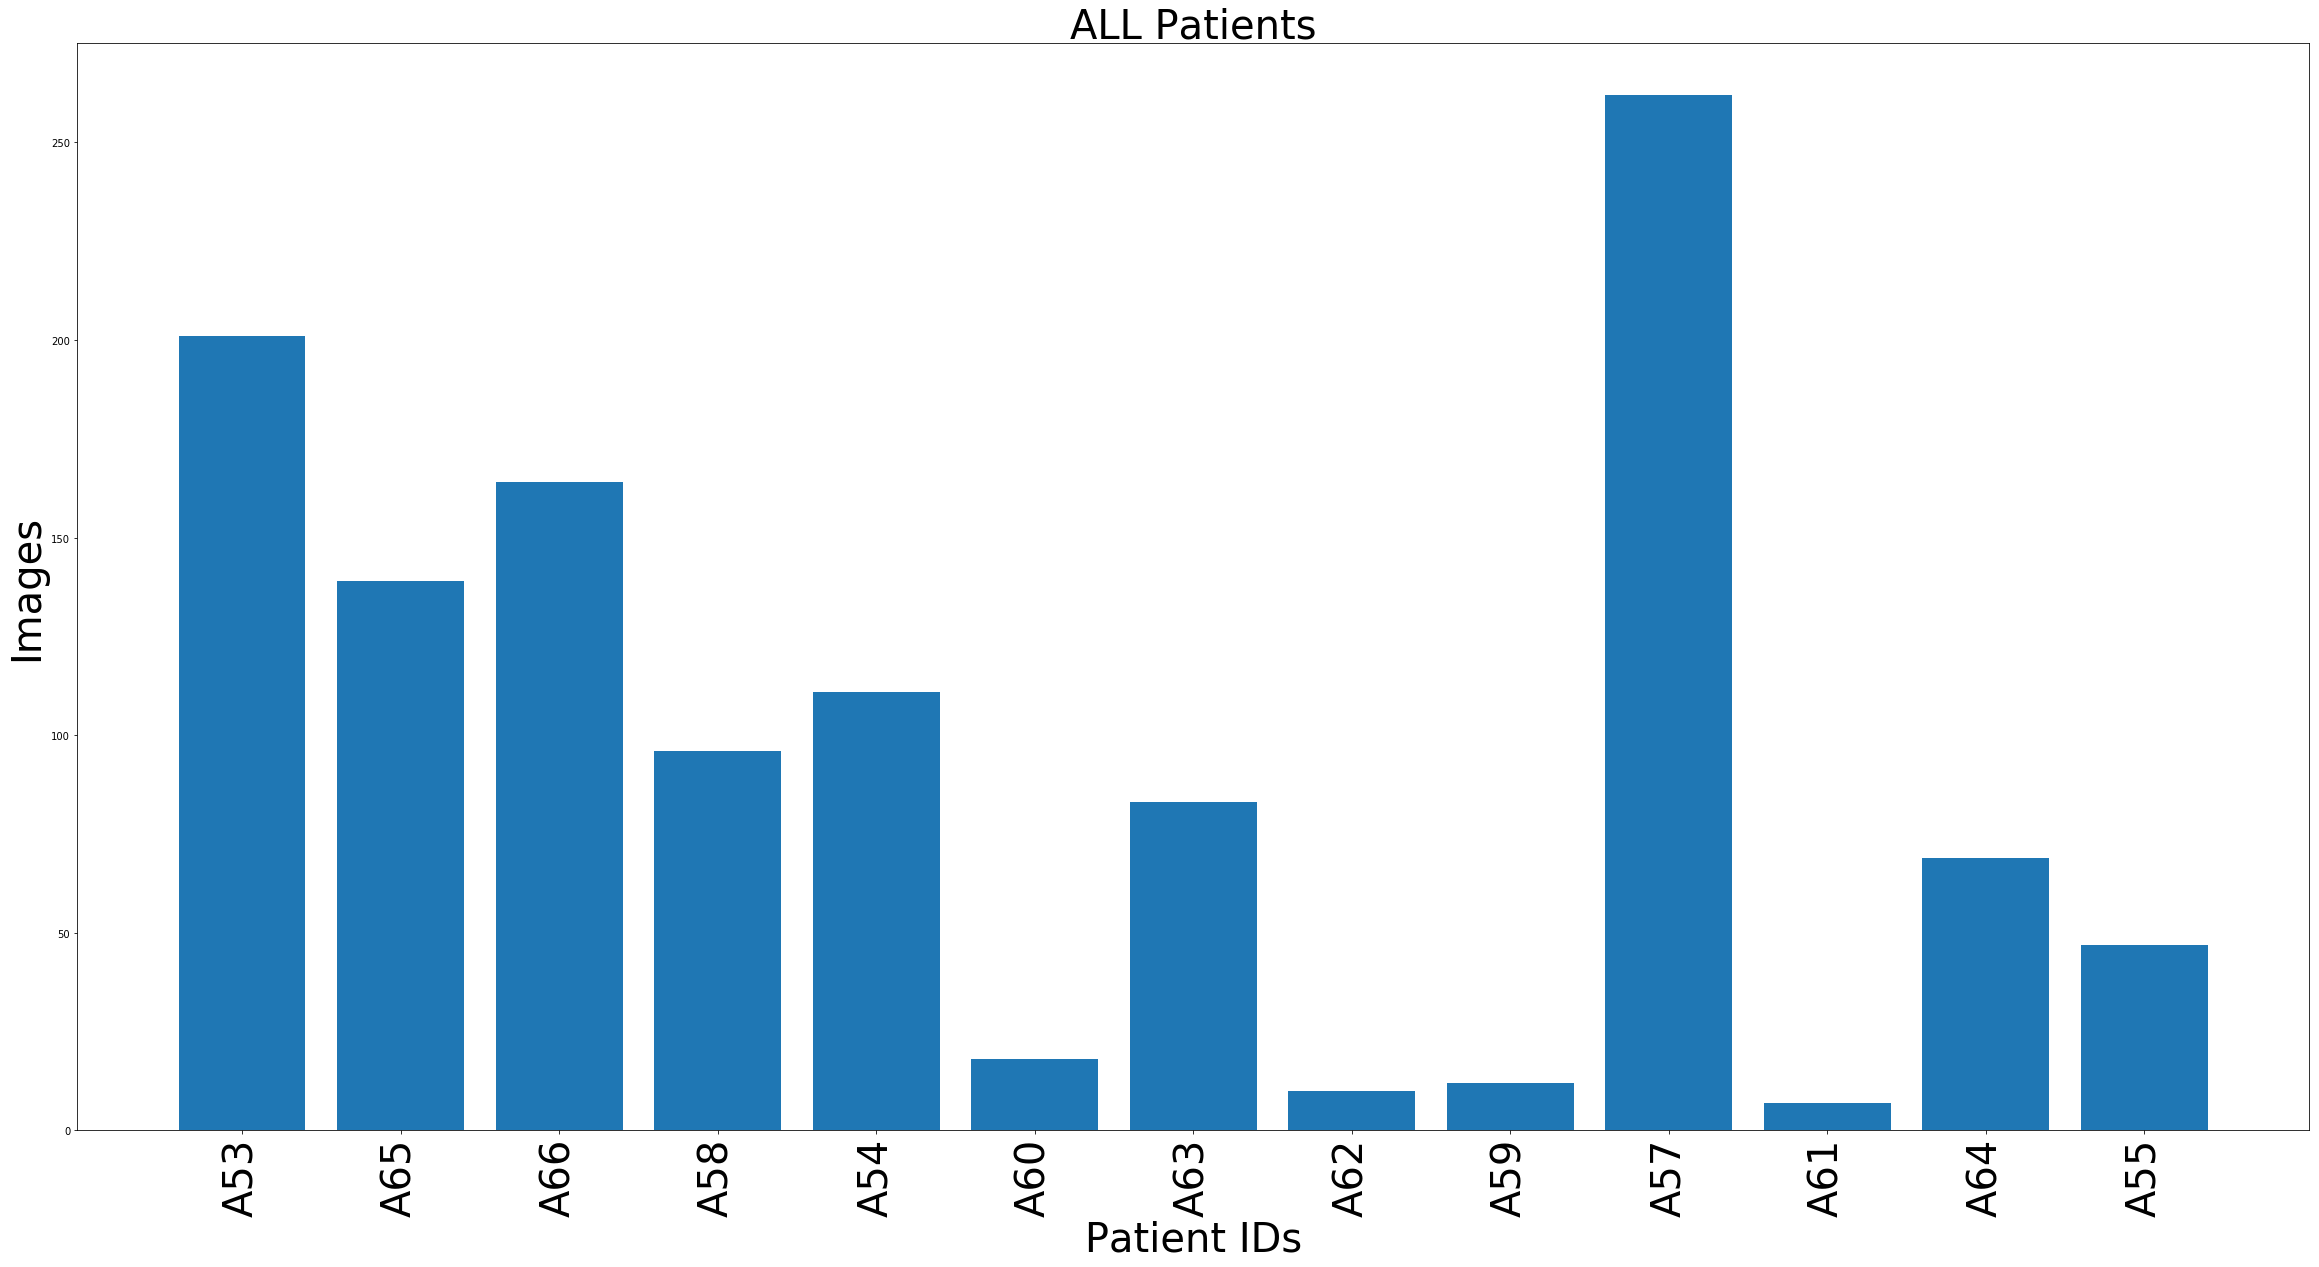

In [217]:
labels, sizes = zip(*[('A{}'.format(key), len(all_patints[key])) for key in all_patints.keys()])
x_pos = [i for i, _ in enumerate(labels)]

print(np.mean(sizes))
print(min(sizes))
print(max(sizes))

plt.figure(figsize=(40,20))
plt.bar(x_pos, sizes)
plt.xlabel("Patient IDs", fontsize=40)
plt.ylabel("Images", fontsize=40)
plt.title("ALL Patients", fontsize=40)

#for i, v in enumerate(sizes):
#    plt.text(x=v,y=i,s=str(v), color='blue', fontweight='bold', fontsize=40)

plt.xticks(x_pos, labels, rotation='vertical', fontsize=40)
plt.show()

43.2
5
162


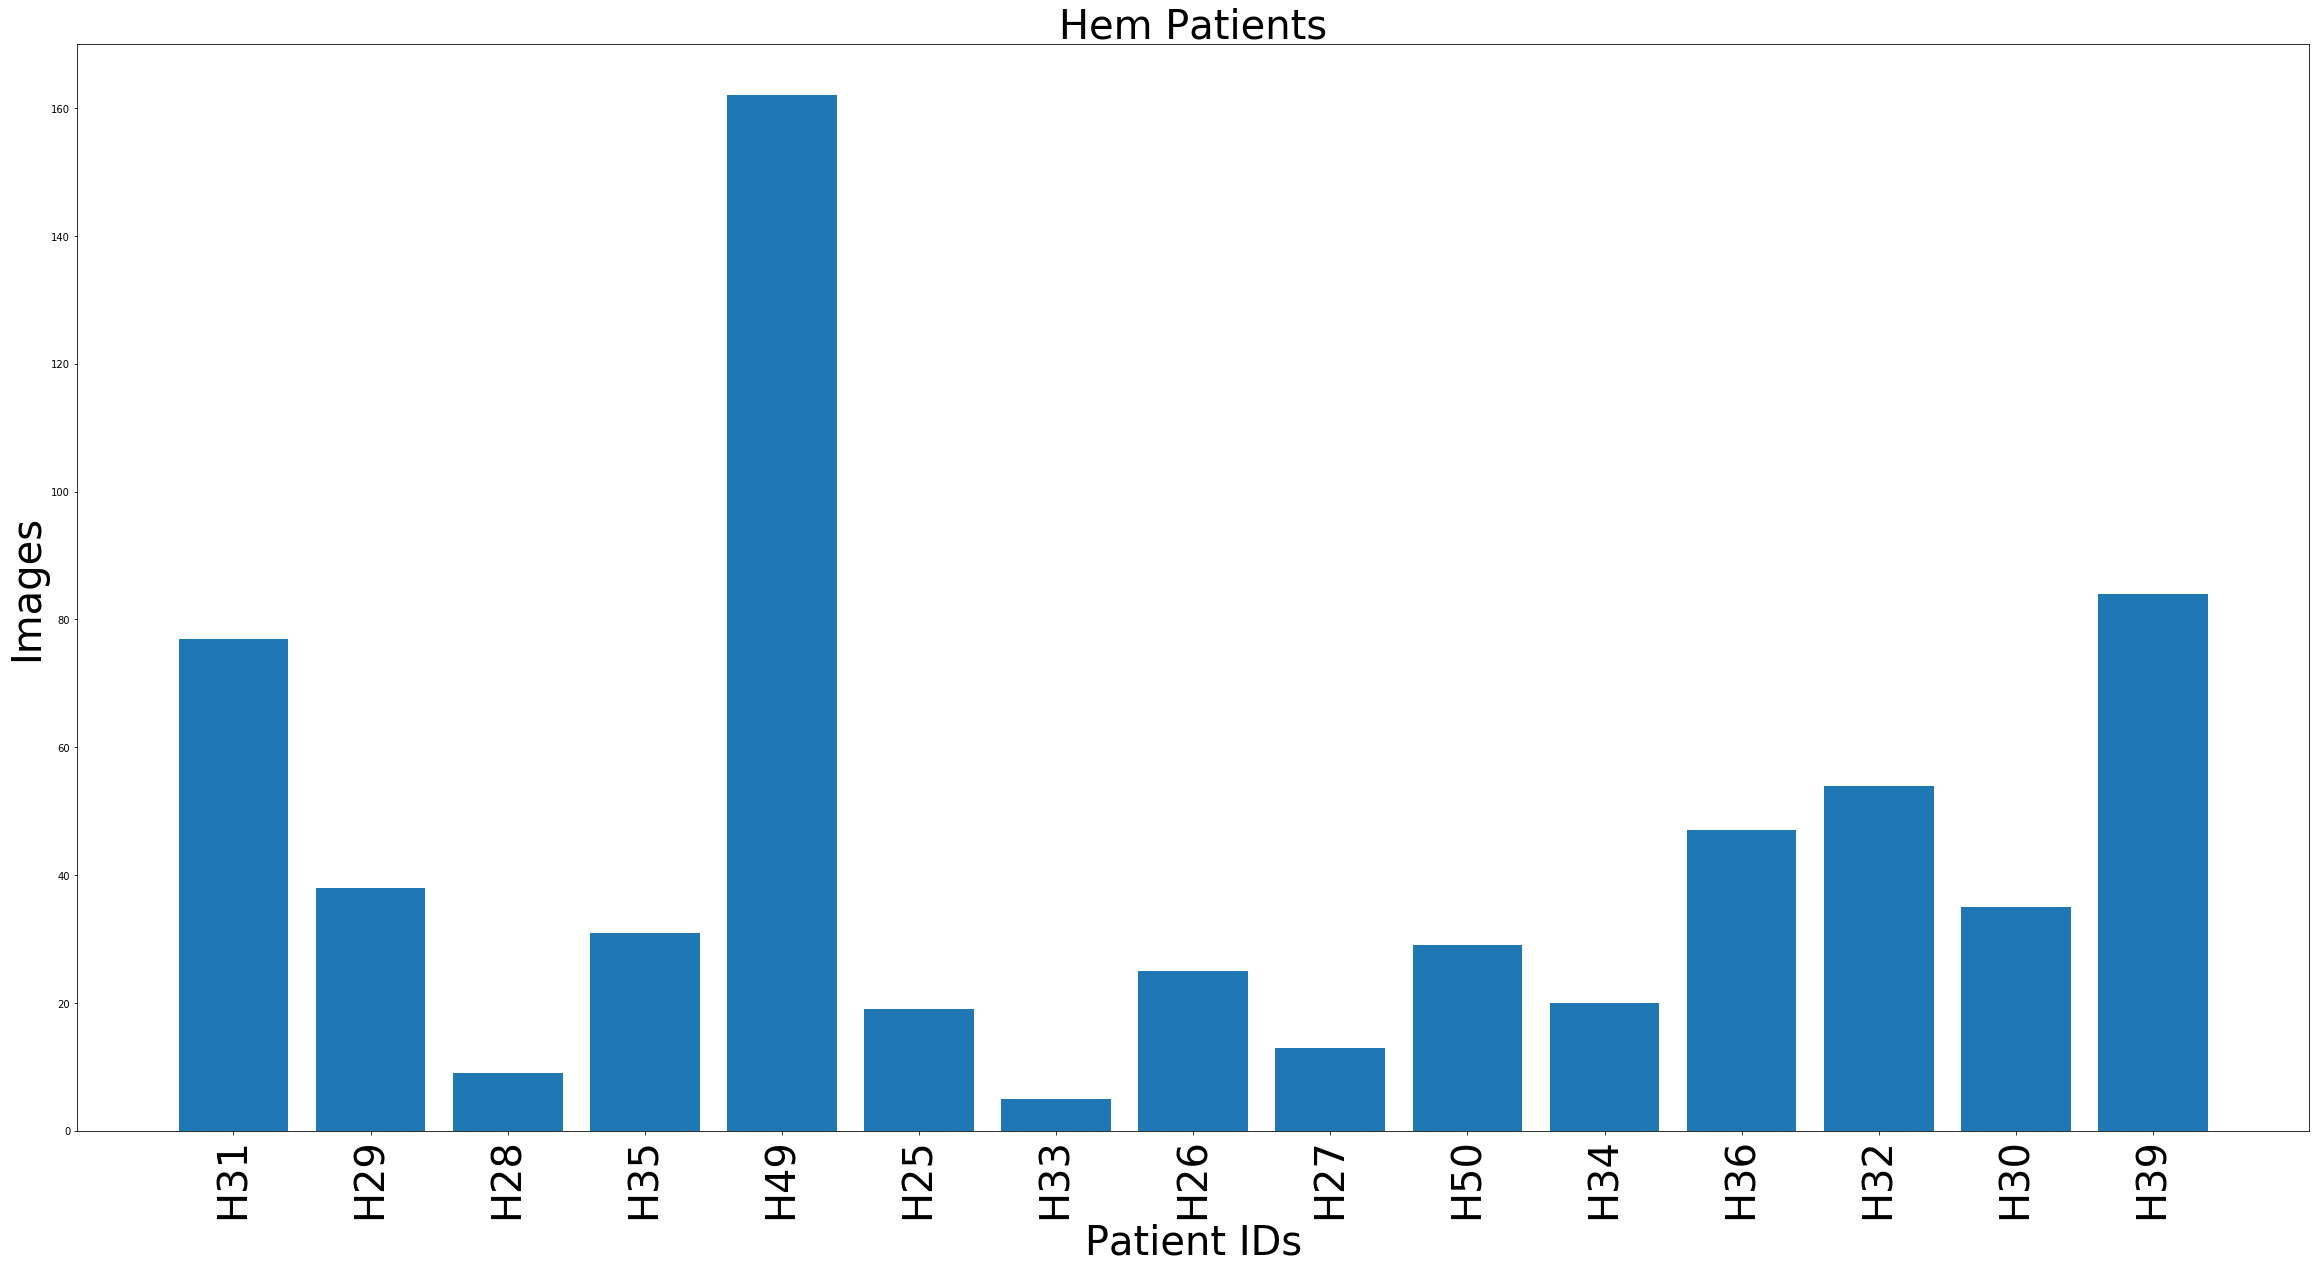

In [218]:
labels, sizes = zip(*[(key, len(hem_patients[key])) for key in hem_patients.keys()])
x_pos = [i for i, _ in enumerate(labels)]

print(np.mean(sizes))
print(min(sizes))
print(max(sizes))

plt.figure(figsize=(40,20))
plt.bar(x_pos, sizes)
plt.xlabel("Patient IDs", fontsize=40)
plt.ylabel("Images", fontsize=40)
plt.title("Hem Patients", fontsize=40)

plt.xticks(x_pos, labels, rotation='vertical', fontsize=40)
plt.show()

In [189]:
file = "/server/born_pix/EPA_DATASETS/WhiteBloodCancer/VAL_ISBI_labelfile_Source_reference_prediction.csv"
dataset = pd.read_csv(file, delimiter=';') 
dataset.head()

,Patient_ID,new_names,labels,prediction,prediction_patient
0,UID_57_29_1_all.bmp,1.bmp,1,1,1
1,UID_57_22_2_all.bmp,2.bmp,1,1,1
2,UID_57_31_3_all.bmp,3.bmp,1,1,1
3,UID_H49_35_1_hem.bmp,4.bmp,0,0,0
4,UID_58_6_13_all.bmp,5.bmp,1,1,1


In [190]:
gt_labels = np.array(dataset.loc[:, 'labels'])
prediction_labels = np.array(dataset.loc[:, 'prediction'])

In [170]:
f1_score(gt_labels, prediction_labels, average='weighted')

0.8746120516740401

In [171]:
precision_recall_fscore_support(gt_labels, prediction_labels, average='weighted')

(0.8753285230261421, 0.8762720942688805, 0.8746120516740401, None)

In [172]:
precision_recall_fscore_support(gt_labels, prediction_labels, average='weighted',labels=[1]) #ALL

(0.8847352024922117, 0.9319114027891715, 0.9077107471034759, None)

In [173]:
precision_recall_fscore_support(gt_labels, prediction_labels, average='weighted',labels=[0]) #HEM

(0.8576329331046313, 0.7716049382716049, 0.8123476848090982, None)

In [174]:
results = []
for pad in hem_patient_ids:
    patient_ds = dataset.loc[dataset['Patient_ID'].str.contains(f'UID_{pad}_')]
    
    gt_labels = np.array(patient_ds.loc[:, 'labels'])
    prediction_labels = np.array(patient_ds.loc[:, 'prediction'])
    
    accuracy = accuracy_score(gt_labels, prediction_labels)
    
    results.append(np.array([f'UID_{pad}', accuracy]))
hem_results = np.array(results)
hem_df = pd.DataFrame(hem_results, columns=['Patient_ID', 'acc'])

print(np.mean(hem_results[:, 1].astype(np.float)))
hem_df.head()

0.659941422206597


,Patient_ID,acc
0,UID_H31,0.8181818181818182
1,UID_H29,0.2894736842105263
2,UID_H28,0.6666666666666666
3,UID_H35,0.3870967741935484
4,UID_H49,0.9506172839506173


In [175]:
results = []
for pad in all_patint_ids:
    patient_ds = dataset.loc[dataset['Patient_ID'].str.contains(f'UID_{pad}_')]
    
    gt_labels = np.array(patient_ds.loc[:, 'labels'])
    prediction_labels = np.array(patient_ds.loc[:, 'prediction'])
    
    accuracy = accuracy_score(gt_labels, prediction_labels)
    
    results.append(np.array([f'UID_{pad}', accuracy]))
all_results = np.array(results)
all_df = pd.DataFrame(np.array(results), columns=['Patient_ID', 'acc'])

print(np.mean(all_results[:, 1].astype(np.float)))
all_df.head()

0.8640746975738498


,Patient_ID,acc
0,UID_53,0.945273631840796
1,UID_65,0.9640287769784173
2,UID_66,0.9573170731707317
3,UID_58,0.8020833333333334
4,UID_54,1.0


In [82]:
all_df.to_csv(path_or_buf='ALL-Patients.csv', sep=';', index=False)
hem_df.to_csv(path_or_buf='Hem-Patients.csv', sep=';', index=False)

In [179]:
temp = pd.concat([all_df, hem_df])

,Patient_ID,acc
0,UID_53,0.945273631840796
1,UID_65,0.9640287769784173
2,UID_66,0.9573170731707317
3,UID_58,0.8020833333333334
4,UID_54,1.0


In [187]:
acc_by_patients = []
for index, row in dataset.iterrows():
    patient_acc = float(np.array(temp.loc[temp['Patient_ID']
                                 .str.contains("_".join(row['Patient_ID'].split('_')[:2]))])[0][1])

    label = int(row['labels'])
    if patient_acc > 0.5:
        acc_by_patients.append(label)
    else:
        if label == 0: acc_by_patients.append(1)
        else: acc_by_patients.append(0)

In [198]:
precision_recall_fscore_support(gt_labels, acc_by_patients, average='weighted')

(0.9357705301990663, 0.9287627209426889, 0.9265319764382255, None)

In [199]:
precision_recall_fscore_support(gt_labels, acc_by_patients, average='weighted',labels=[1]) #ALL

(0.9016272189349112, 1.0, 0.9482691559704396, None)

In [200]:
precision_recall_fscore_support(gt_labels, acc_by_patients, average='weighted',labels=[0]) #HEM

(1.0, 0.7947530864197531, 0.8856405846947549, None)

In [213]:
import os 


txt_files = [file for file in os.listdir('/data/Datasets/WhiteBloodCancer/train/') 
             if file.endswith('.txt')]
pkl_files = [file for file in os.listdir('/data/Datasets/WhiteBloodCancer/train/') 
             if file.endswith('.pkl') and '-450-' in file]

In [214]:
txt_files

['rn50-Final-101-101.txt',
 'rn50-Final-101-115.txt',
 'rn50-Final-100-102.txt',
 'rn50-Final-100-110.txt',
 'rn50-Final-100-106.txt',
 'rn50-Final-100-122.txt',
 'rn50-Final-100-112.txt',
 'rn50-Final-101-111.txt',
 'rn50-Final-100-104.txt',
 'rn50-Final-101-107.txt',
 'rn50-Final-100-124.txt',
 'rn50-Final-100-108.txt',
 'rn50-Final-101-103.txt',
 'rn50-Final-100-118.txt',
 'rn50-Final-101-117.txt',
 'rn50-Final-101-105.txt',
 'rn50-Final-101-125.txt',
 'rn50-Final-101-119.txt',
 'rn50-Final-100-116.txt',
 'rn50-Final-100-120.txt',
 'rn50-Final-101-123.txt',
 'rn50-Final-100-100.txt',
 'rn50-Final-101-109.txt',
 'rn50-Final-101-113.txt',
 'rn50-Final-100-114.txt',
 'rn50-Final-101-121.txt']

In [215]:
pkl_files

['5604-450-rn50-Final-100-104.pkl',
 '9298-450-rn50-Final-101-107.pkl',
 '8311-450-rn50-Final-100-124.pkl',
 '9202-450-rn50-Final-101-115.pkl',
 '9555-450-rn50-Final-100-100.pkl',
 '9437-450-rn50-Final-101-121.pkl',
 '9259-450-rn50-Final-100-116.pkl',
 '9380-450-rn50-Final-101-103.pkl',
 '9482-450-rn50-Final-101-101.pkl',
 '7057-450-rn50-Final-100-108.pkl',
 '9333-450-rn50-Final-101-111.pkl',
 '9323-450-rn50-Final-101-123.pkl',
 '9469-450-rn50-Final-101-109.pkl',
 '9423-450-rn50-Final-101-117.pkl',
 '5629-450-rn50-Final-100-112.pkl',
 '8818-450-rn50-Final-100-110.pkl',
 '9516-450-rn50-Final-101-119.pkl',
 '9446-450-rn50-Final-101-105.pkl',
 '8855-450-rn50-Final-100-106.pkl',
 '9112-450-rn50-Final-100-122.pkl',
 '9591-450-rn50-Final-100-102.pkl',
 '9385-450-rn50-Final-101-113.pkl',
 '4239-450-rn50-Final-100-114.pkl',
 '6893-450-rn50-Final-100-120.pkl',
 '8370-450-rn50-Final-100-118.pkl']